In [112]:
import math
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
import unittest

In [113]:
%matplotlib inline

The purpose of this notebook is to build out the original transformer from scratch, and train it on a toy task of predicting the continuation of a sequence of 1s and 0s.

In [122]:
class CausalSelfAttention(nn.Module):
    """
    A vanilla multi-head masked self-attention layer with a projection at the end.
    It is possible to use torch.nn.MultiheadAttention here but I am including an
    explicit implementation here to show that there is nothing too scary here.
    """

    def __init__(self, n_embd, n_head, resid_pdrop=0, attn_pdrop=0, block_size=10):
        super().__init__()
        # key, query, value projections for all heads, but in a batch
        self.c_attn = nn.Linear(n_embd, 3 * n_embd)
        # output projection
        self.c_proj = nn.Linear(n_embd, n_embd)
        # regularization
        self.attn_dropout = nn.Dropout(attn_pdrop)
        self.resid_dropout = nn.Dropout(resid_pdrop)
        # causal mask to ensure that attention is only applied to the left in the input sequence
    
        self.n_head = n_head
        self.n_embd = n_embd

        self.apply(self._init_weights)
        for pn, p in self.named_parameters():
            if pn.endswith('c_proj.weight'):
                torch.nn.init.normal_(p, mean=0.0, std=0.02/math.sqrt(2 * 1))
    
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
        elif isinstance(module, nn.LayerNorm):
            torch.nn.init.zeros_(module.bias)
            torch.nn.init.ones_(module.weight)

    def forward(self, x):
        B, T, C = x.size()  # batch size, sequence length, embedding dimensionality (n_embd)

        # calculate query, key, values for all heads in batch and move head forward to be the batch dim
        q, k, v = self.c_attn(x).split(self.n_embd, dim=2)
        
        k = k.view(B, T, self.n_head, C //
                   self.n_head).transpose(1, 2)  # (B, nh, T, hs)
        q = q.view(B, T, self.n_head, C //
                   self.n_head).transpose(1, 2)  # (B, nh, T, hs)
        v = v.view(B, T, self.n_head, C //
                   self.n_head).transpose(1, 2)  # (B, nh, T, hs)

        # causal self-attention; Self-attend: (B, nh, T, hs) x (B, nh, hs, T) -> (B, nh, T, T)
        att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
        att = F.softmax(att, dim=-1)
        att = self.attn_dropout(att)
        y = att @ v  # (B, nh, T, T) x (B, nh, T, hs) -> (B, nh, T, hs)
        # re-assemble all head outputs side by side
        y = y.transpose(1, 2).contiguous().view(B, T, C)

        # output projection
        y = self.resid_dropout(self.c_proj(y))
        return y

class Conf():
    def __init__(self, n_emb, n_head):
        self.n_embd = n_emb
        self.n_head = n_head
        self.attn_pdrop = 0.0
        self.resid_pdrop = 0.0
        self.block_size = 10

In [198]:
from torch import seed


class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super().__init__()
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"
        self.d_model = d_model
        self.num_heads = num_heads
        self.head_size = d_model // num_heads
        self.q = nn.Linear(d_model, d_model)
        self.k = nn.Linear(d_model, d_model)
        self.v = nn.Linear(d_model, d_model) 
        self.projection = nn.Linear(d_model, d_model)

    def forward(self, x, src_mask=None, tgt_mask=None, memory=None):
        B, T, C = x.size()  # batch size, sequence length, model dimensionality.

        if memory is None:
            query, key, value = self.q(x), self.k(x), self.v(x)
        else:
            query, key, value = self.q(x), self.k(memory), self.v(memory)

        # split the input into multiple heads.
        #
        # the reason for the transpose is to be able to use .view()
        # without having to call .contigous().
        query = self.q(query).view(B, T, self.num_heads, self.head_size).permute(0, 2, 1, 3) # B, num_heads, T, head_size
        key =   self.k(key).view(  B, T, self.num_heads, self.head_size).permute(0, 2, 1, 3) # B, num_heads, T, head_size
        value = self.v(value).view(B, T, self.num_heads, self.head_size).permute(0, 2, 1, 3) # B, num_heads, T, head_size

        # calculate the attention.
        attention = query @ key.transpose(-1, -2)

        # apply masks if applicable.
        if src_mask is not None:
            attention.masked_fill_(src_mask.unsqueeze(0)[:, :, :T, :T], float('-inf'))
        if tgt_mask is not None:
            attention.masked_fill_(tgt_mask.unsqueeze(0)[:, :, :T, :T], float('-inf'))

        # scale the scores with the sqrt of the query and key dimensionality.
        # the reason for this is that the more dimensions you add to query and key,
        # the larger the values will be in the resulting matrix.
        attention /= math.sqrt(query.shape[-1])

        # calculate softmaxed attention scores.
        scores = F.softmax(attention, dim=-1)

        # score the value vectors.
        y = scores @ value
        
        # concatenate the heads back together.
        # B, T, num_heads, head_size -> B, T, num_heads * head_size
        y = y.transpose(1, 2).contiguous().view(B, T, C)

        return self.projection(y)

### Verify that it works

In [185]:
torch.manual_seed(0)
n_epochs = 50
target = 0.4
lrs = torch.linspace(2, 0.01, n_epochs)
x, y = torch.arange(100).view(1, 10, 10).float() / 100, torch.arange(-50, 50).view(1, 10, 10).float() / 50

def train(model, x, y, n_epochs, pytorch = False):
    torch.manual_seed(0)

    loss = 0

    for _ in range(n_epochs):
        if pytorch:
            y_hat = model(x, x, x)[0]

        else:
            y_hat = model(x)
        
        
        loss = F.mse_loss(y_hat, y)


        for p in model.parameters():
            p.grad = None

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)

        for p in model.parameters():
            if p.grad is not None:
                p.data += -lrs[_] * p.grad
            
    return loss

class TestTrainModels(unittest.TestCase):
    """
    These tests are stochastic and can fail if you're unlucky with initialization.
    """
    
    def test_train_custom(self):
        model = MultiHeadAttention(10, 2)
        print("Created custom model with {} parameters".format(sum(p.numel() for p in model.parameters())))
        loss = train(model, x, y, n_epochs)
        self.assertTrue(loss < target)

    def test_train_mingpt(self):    
        model = CausalSelfAttention(10, 2)
        print("Created minGPT model with {} parameters".format(sum(p.numel() for p in model.parameters())))
        loss = train(model, x, y, n_epochs)
        self.assertTrue(loss < target)

    def test_train_pytorch(self):
        model = nn.MultiheadAttention(10, 2)
        print("Created PyTorch model with {} parameters".format(sum(p.numel() for p in model.parameters())))
        loss = train(model, x, y, n_epochs, True)
        self.assertTrue(loss < target)

The PyTorch implementation trains faster, but all models converge to a low loss.

In [186]:
class EncoderBlock(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super().__init__()
        self.attention = MultiHeadAttention(d_model, num_heads)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.ff = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.ReLU(),
            nn.Linear(d_ff, d_model)
        )
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        y = self.attention(x, src_mask=mask)
        y = self.dropout(y)
        y += x
        y = self.norm1(y)
        y = self.ff(y)
        y = self.dropout(y)
        y += x
        return self.norm2(y)

class TestEncoderBlock(unittest.TestCase):
    def test_encoder(self):
        block = EncoderBlock(10, 2, 20)
        x = torch.randn(1, 10, 10)
        y = block(x)
        self.assertEqual(y.shape, x.shape)

In [187]:
class DecoderBlock(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super().__init__()
        self.attention = MultiHeadAttention(d_model, num_heads)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.ff = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.ReLU(),
            nn.Linear(d_ff, d_model)
        )
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, memory, src_mask=None, tgt_mask=None):
        y = self.attention(x, src_mask=tgt_mask, tgt_mask=tgt_mask)
        y = self.dropout(y)
        y += x
        y = self.norm1(y)
        y = self.attention(y, src_mask=src_mask, tgt_mask=tgt_mask, memory=memory)
        y = self.dropout(y)
        y += x
        y = self.norm2(y)
        y = self.ff(y)
        y = self.dropout(y)
        y += x
        return self.norm3(y)

class TestDecoderBlock(unittest.TestCase):
    def test_decoder(self):
        block = DecoderBlock(10, 2, 20)
        x = torch.randn(1, 10, 10)
        y = block(x, x)
        self.assertEqual(y.shape, x.shape)

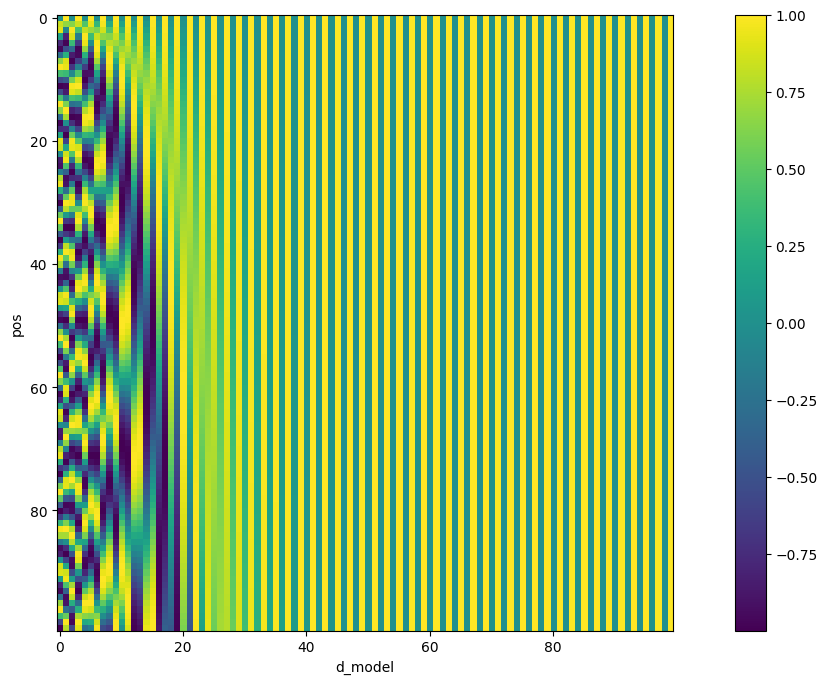

In [188]:
class PositionalEncodings(nn.Module):
    def __init__(self, d_model, max_len=1000):
        super().__init__()
        self.d_model = d_model
        pe = torch.zeros(max_len, d_model)
        for pos in range(max_len):
            for i in range(0, d_model, 2):
                pe[pos, i] = math.sin(pos / (10000 ** ((2 * i) / d_model)))
                pe[pos, i + 1] = math.cos(pos / (10000 ** ((2 * (i + 1)) / d_model)))
        
        self.register_buffer("pe", pe, persistent=False)

    def forward(self, x):
        return x + self.pe[:x.size(1), :].unsqueeze(0)
    
    def visualize(self):
        plt.figure(figsize=(16, 8))
        plt.imshow(self.pe.detach().numpy())
        plt.xlabel("d_model")
        plt.ylabel("pos")
        plt.colorbar()
        plt.show()

class TestPositionalEncodings(unittest.TestCase):
    def test_positional_encodings_shape(self):
        pe = PositionalEncodings(10)
        x = torch.randn(1, 10, 10)
        y = pe(x)
        self.assertEqual(y.shape, x.shape)

    def test_positional_encodings_diff(self):
        pe = PositionalEncodings(10)
        x = torch.randn(1, 10, 10)
        y = pe(x)
        for i in range(1, 10):
            for j in range(1, 10):
                self.assertNotEqual(x[0, i, j], y[0, i, j])

PositionalEncodings(100, max_len=100).visualize()

In [189]:
class Transformer(nn.Module):
    def __init__(self, src_vocab, tgt_vocab, d_model, num_heads, d_ff, num_layers, dropout=0.1, tie_weights=True):
        super().__init__()
        self.d_model = d_model
        self.src_embedding = nn.Embedding(src_vocab, d_model)

        if tie_weights:
            assert src_vocab == tgt_vocab, "To tie word embedding weights, the vocabulary size of src and tgt must be the same."
            self.tgt_embedding = self.src_embedding
        else:
            self.tgt_embedding = nn.Embedding(tgt_vocab, d_model)

        self.pos_enc = PositionalEncodings(d_model)
        self.encoder = nn.ModuleList([EncoderBlock(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])
        self.decoder = nn.ModuleList([DecoderBlock(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])
        self.generator = nn.Linear(d_model, tgt_vocab, bias=False)

        if tie_weights:
            self.generator.weight = self.tgt_embedding.weight

        self._reset_parameters()
        
    def _reset_parameters(self):
        for p in self.parameters():
            if p.dim() > 1:    
                torch.nn.init.xavier_uniform_(p)

    def decode(self, x):
        self.decoder()

    def forward(self, src, tgt, src_mask=None, tgt_mask=None):
        src = self.pos_enc(self.src_embedding(src) * math.sqrt(self.d_model))
        tgt = self.pos_enc(self.tgt_embedding(tgt) * math.sqrt(self.d_model))

        for layer in self.encoder:
            src = layer(src, src_mask)
        for layer in self.decoder:
            tgt = layer(tgt, src, src_mask, tgt_mask)

        return self.generator(tgt)

t = Transformer(128, 128, 128, 4, 256, 2)
t(torch.randint(0, 128, (1, 10)), torch.randint(0, 128, (1, 10))).shape

torch.Size([1, 10, 128])

# Verify that the initialization of the net looks good.

layer 0 (Linear(in_features=64, out_features=64, bias=True)): mean +0.08, std 1.29, saturated: 44.53%
layer 1 (Linear(in_features=64, out_features=64, bias=True)): mean -0.01, std 1.08, saturated: 38.59%
layer 2 (Linear(in_features=64, out_features=64, bias=True)): mean +0.02, std 1.35, saturated: 45.94%
layer 3 (Linear(in_features=64, out_features=64, bias=True)): mean +0.08, std 1.04, saturated: 34.69%
layer 4 (Linear(in_features=64, out_features=256, bias=True)): mean -0.02, std 0.65, saturated: 14.02%
layer 5 (Linear(in_features=256, out_features=64, bias=True)): mean -0.03, std 0.57, saturated: 8.12%
layer 6 (Linear(in_features=64, out_features=64, bias=True)): mean -0.01, std 0.96, saturated: 33.75%
layer 7 (Linear(in_features=64, out_features=64, bias=True)): mean -0.13, std 0.92, saturated: 28.44%
layer 8 (Linear(in_features=64, out_features=64, bias=True)): mean +0.02, std 0.97, saturated: 30.62%
layer 9 (Linear(in_features=64, out_features=64, bias=True)): mean -0.05, std 0.4

Text(0.5, 1.0, 'activation distribution')

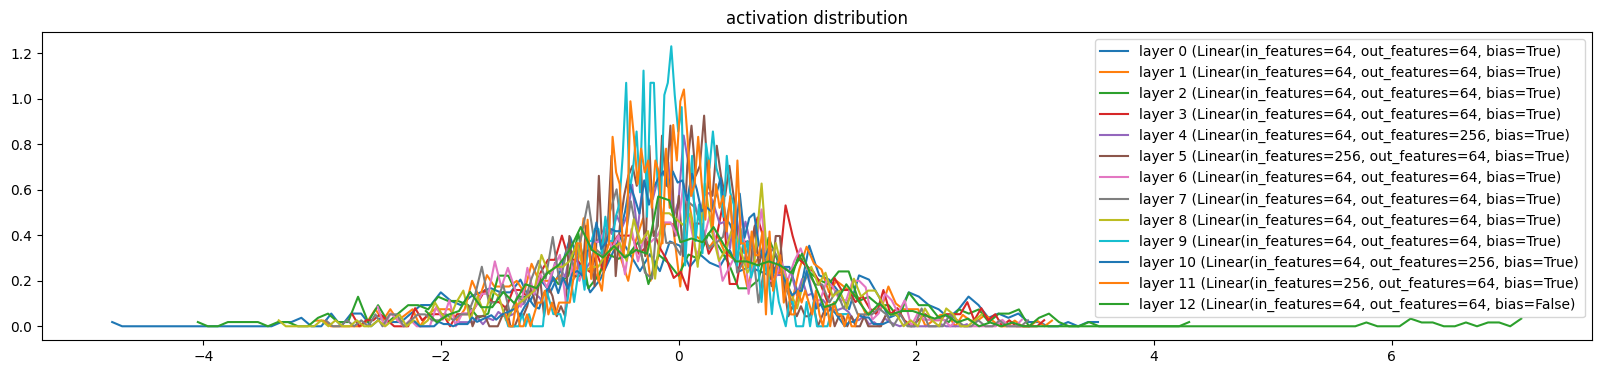

In [190]:
activations = {}

model = Transformer(64, 64, 64, 2, 256, 1)

def register_hook(name):
    def hook(model, input, output):
        activations[name] = output.detach()
    return hook

# add the hooks
for m in model.modules():
  if isinstance(m, nn.Linear):
    m.register_forward_hook(register_hook(m))

# run the model
model(torch.randint(0, 64, (1, 10)), torch.randint(0, 64, (1, 10)))

# visualize the activations
plt.figure(figsize=(20, 4))
legends = []

for i, key in enumerate(activations):
  t = activations[key]
  if isinstance(t, tuple):
    break
  print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, key, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
  hy, hx = torch.histogram(t, density=True)
  plt.plot(hx[:-1].detach(), hy.detach())
  legends.append(f'layer {i} ({key}')
plt.legend(legends);
plt.title('activation distribution')

In [191]:
unittest.main(argv=[''], verbosity=1, exit=False)

.......
----------------------------------------------------------------------
Ran 7 tests in 0.247s

OK


Created custom model with 440 parameters
Created minGPT model with 440 parameters
Created PyTorch model with 440 parameters


# Training the model

Let's see if the model can learn a basic copying function.

In [233]:
torch.manual_seed(0)

src = torch.arange(11).unsqueeze(0)
mask = torch.triu(torch.ones(10, 10), diagonal=1).bool().unsqueeze(0)

n_epochs = 10
lr = 10

model_custom = Transformer(20, 20, 20, 2, 100, 1, dropout=0)
model_pytorch = nn.Transformer(d_model=20, nhead=2, num_encoder_layers=1, num_decoder_layers=1, dim_feedforward=100, dropout=0.0)

def train(model, src, n_epochs):
    loss = 0

    for _ in range(n_epochs):
        x = src[:, :-1]
        y = src[:, 1:]

        logits = model(x, y, src_mask=None, tgt_mask=mask)

        loss = F.cross_entropy(logits.permute(0, 2, 1), y)

        for p in model.parameters():
            p.grad = None

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)

        for p in model.parameters():
            if p.grad is not None:
                p.data += -lr * p.grad

        if _ % (n_epochs / 10) == 0:
            print(loss.item())
            
    return loss

print("="*20, "Custom", "="*20)
loss = train(model_custom, src, n_epochs)
print("="*20, "PyTorch", "="*20)
loss = train(model_pytorch, src, n_epochs)


==================== Custom ====================
0.7140170335769653
0.14400020241737366
0.024237697944045067
0.006957602687180042
0.00471861194819212
0.003588462248444557
0.00289659621194005
0.0024272105656564236
0.002087313449010253
0.0018296046182513237
==================== PyTorch ====================


RuntimeError: the feature number of src and tgt must be equal to d_model